Имея решение `1d`  задачи для двух жидкостей, можем получить `2d` решение

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display

In [226]:
nx = 25
ny = 25
k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 3 # m
dy = 3 # m
phi = 0.4
p_0 = 150 * 10 ** 5  # psi to Pa
d = 10  # m
dt = 30  # s
s_0 = 0.9
s_b = 0.1
p = np.ones((nx, ny)) * p_0
s_o = np.ones((nx, ny)) * s_0
s_w = np.ones((nx, ny))* (1 - s_0)

Перейдём к сжимаемости для [rock](https://www.sciencedirect.com/topics/engineering/formation-compressibility), [water and oil](http://www.fekete.com/san/webhelp/feketeharmony/harmony_webhelp/content/html_files/reference_material/general_concepts/reservoir_properties.htm)

In [227]:
c_w = 1e-6 # # Pa^-1
c_o = 1e-6 # # Pa^-1
c_r = 3e-6 #  Pa^-1 

Также различаются вязкости [oil](https://petrowiki.org/Oil_viscosity) и [water](http://fekete.com/SAN/TheoryAndEquations/HarmonyTheoryEquations/Content/HTML_Files/Reference_Material/General_Concepts/Reservoir_Fluid_Properties.htm)

In [228]:
B_o = 1
B_w = 1
mu_o = 15 / 1000 # cp to Pa * s
mu_w = 1 / 1000 # cp to Pa * s

Такс, вводим гиперпараметры для относитльной проницаемости

In [229]:
l_w = 2.
l_o = 2.
s_wir = 0.2
s_wor = 0.8
k_rwr = 0.1
k_rot = 1.
e_w = 1.
e_o = 1.
t_w = 2.
t_o = 2.

In [230]:
def get_s_wn(s_w):
    s_wn = (s_w - s_wir) / (s_wor - s_wir)
    if (s_wn < 0):
        s_wn = 0
    if (s_wn > 1):
        s_wn = 1
    return s_wn


def k_rel_w(s_w):
    s_wn = get_s_wn(s_w)
    out = s_wn ** l_w * k_rwr
    out /= s_wn ** l_w + e_w * (1 - s_wn) ** t_w
    return out

def k_rel_o(s_o):
    s_w = 1 - s_o
    s_wn = get_s_wn(s_w)
    out = k_rot * (1 - s_wn) ** l_o
    out /= (1 - s_wn) ** l_o + e_o * s_wn ** t_o
    return out

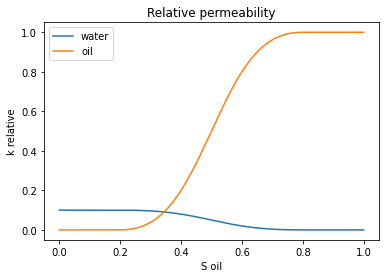

In [231]:
ss = np.linspace(0, 1, 200)
k_rels_w = [k_rel_w(1-s) for s in ss]
k_rels_o = [k_rel_o(s) for s in ss]
plt.plot(ss, k_rels_w, label='water')
plt.plot(ss, k_rels_o, label='oil')
plt.xlabel('S oil')
plt.ylabel("k relative")
plt.title('Relative permeability')
plt.legend()
plt.show()

Оставим тут класс, который соержит в себе граничные значения.

In [232]:
class ResState:
    def __init__(self, values, bound_value):
        self.values = values
        self.bound_v = bound_value
        self.shape = values.shape
    def __getitem__(self, item):
        i, j = item
        if (i < 0) | (j < 0) | (i > self.shape[0]-1) | (j > self.shape[1]-1):
            return self.bound_v
        else:
            return self.values[i, j]

In [233]:
p = ResState(p, p_0)
s_o = ResState(s_o, s_b)
s_w = ResState(s_w, 1 - s_b)

Дальше немного сложенее - теперь нужно вводить межблочную относительную проницаемость

Раньше `i` и `j` это номера соседних ячеек по единственной оси.
Теперь это будет номер "межблока", например (0.5, 1)

In [234]:
from math import ceil, floor

In [235]:
def k_rel_ph(i, j, s, p, ph):
    out = 0
    if p[ceil(i), ceil(j)] >= p[floor(i), floor(j)]:
        out = k_rel_ph_1val(s=s[ceil(i), ceil(j)], ph=ph)
    elif p[floor(i), floor(j)] >= p[ceil(i), ceil(j)]:
        out = k_rel_ph_1val(s=s[floor(i), floor(j)], ph=ph)
    else:
        print('Dunnow what with k_rel_ph')
    return out

def k_rel_ph_1val(s, ph):
    out = 0
    if ph == 'o':
        out = k_rel_o(s)
    elif ph == 'w':
        out = k_rel_w(s)
    return out

Небольшие изменения потерпит матарица, отвечающая за лапласиан

In [236]:
def two_dim_index_to_one(i: int, j: int, ny: int) -> int:
    return ny * i + j
def one_d_index_to_two(one_d: int, ny: int):
    i = int(one_d / ny)
    j = one_d % ny
    return i, j

In [237]:
def get_lapl_one_ph(p, s, mu, k, d, dx, dy, ph):
    lapl = np.zeros((nx*ny, nx*ny))
    for dia in range(nx*ny):
        i, j = one_d_index_to_two(one_d=dia, ny=ny)
        lapl[dia, dia] -= k * k_rel_ph(i, j-0.5, s, p, ph)
        lapl[dia, dia] -= k * k_rel_ph(i, j+0.5, s, p, ph)
        lapl[dia, dia] -= k * k_rel_ph(i-0.5, j, s, p, ph)
        lapl[dia, dia] -= k * k_rel_ph(i+0.5, j, s, p, ph)
        if j-1 >= 0:
            lapl[dia, dia-1] += k * k_rel_ph(i, j-0.5, s, p, ph)
        if j+1 < ny:
            lapl[dia, dia+1] += k * k_rel_ph(i, j+0.5, s, p, ph)
        if i-1 >= 0:
            dia_ = two_dim_index_to_one(i=i-1, j=j, ny=ny)
            lapl[dia, dia_] += k * k_rel_ph(i-0.5, j, s, p, ph)
        if i+1 < nx:
            dia_ = two_dim_index_to_one(i=i+1, j=j, ny=ny)
            lapl[dia, dia_] += k * k_rel_ph(i+0.5, j, s, p, ph)
    lapl *= d * dy / mu / dx
    return lapl


In [238]:
lapl_w = get_lapl_one_ph(p, s_w, mu_w, k, d, dx, dy, 'w')
lapl_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')

Также изменился вектор для граничных условий

In [239]:
item = (0, 0)

In [240]:
def get_q_bound(p, s, ph, mu):
    out = np.zeros((nx, ny))
    for row in range(nx):
        item = (row, -0.5)
        out[row][0] += k * k_rel_ph(item[0], item[1], s, p, ph) / dx * p[item[0], item[1]]
        item = (row, ny-0.5)
        out[row][ny-1] += k * k_rel_ph(item[0], item[1], s, p, ph) / dx * p[item[0], item[1]]
    
    for col in range(ny):
        item = (-0.5, col)
        out[0][col] += k * k_rel_ph(item[0], item[1], s, p, ph) / dx * p[item[0], item[1]]
        item = (nx-0.5, col)
        out[nx-1][col] += k * k_rel_ph(item[0], item[1], s, p, ph) / dx * p[item[0], item[1]]
    out *= d * dy / mu
    return out.reshape((nx*ny, -1))

In [241]:
q_bound_w = get_q_bound(p, s_w, 'w', mu_w)
q_bound_o = get_q_bound(p, s_o, 'o', mu_o)

Теперь про моделирование скважины

In [242]:
r_ref = 1 / (1 / dx + np.pi / d)

In [243]:
def get_j_matrix(p, s, mu, k, B, pos_r, r_ref, ph):
    out = np.zeros((nx, ny))
    for pos in pos_r:
        out[pos] = 4 * np.pi * k / B / mu
        out[pos] *= r_ref * pos_r[pos]
        out[pos] /= (r_ref + pos_r[pos])
        out[pos] *= k_rel_ph(i=pos[0], j=pos[1], s=s, p=p, ph=ph)
    return out.reshape((nx*ny, 1))

Закинем координаты скважин

In [244]:
pos_r = {(12, 8): 0.1, (18, 21): 0.1}
p_well = np.zeros((nx, ny))
delta_p_well = -100 * 6894.
delta_p_vec = np.ones((nx*ny, 1)) * delta_p_well

In [245]:
j_o = get_j_matrix(p=p, s=s_o, mu=mu_o, k=k, B=B_o, pos_r=pos_r, r_ref=r_ref, ph='o')
j_w = get_j_matrix(p=p, s=s_w, mu=mu_w, k=k, B=B_w, pos_r=pos_r, r_ref=r_ref, ph='w')

И последний штрих - перед производной по времени есть $V_b\big(S_o c_o + S_w c_w  +1\cdot c_r\big)$. Назовём это `dt_comp_sat`

Кстати, у нас теперь `2d` и теперь нужно делать `.reshape`

In [246]:
dt_comp_sat = dx * dy * d *(s_o.values * c_o + s_w.values * c_w + np.ones((nx, ny)) * c_r).reshape((-1, 1))

Закаидываем пареметры для запуска сессии и записи истории

In [247]:
n_iter = int(2e8)
p_ex = np.ones((nx, 1)) * p_0
t = 0
xs = list((np.linspace(0, nx-1, nx) + dx/2) * dx)
plot_freq = int(4e1)
times = []
p_well_hist = {}
s_o_well_hist = {}
q_o_hist = {}
q_w_hist = {}
for w in pos_r:
    p_well_hist[w] = []
    s_o_well_hist[w] = []
    q_o_hist[w] = []
    q_w_hist[w] = []

In [248]:
dt_comp_sat = (dx * dy * d *(s_o.values) * c_o + s_w.values * c_w + np.ones((nx, ny)) * c_r).reshape((-1, 1))
j_o = get_j_matrix(p=p, s=s_o, mu=mu_o, k=k, B=B_o, pos_r=pos_r, r_ref=r_ref, ph='o')
j_w = get_j_matrix(p=p, s=s_w, mu=mu_w, k=k, B=B_w, pos_r=pos_r, r_ref=r_ref, ph='w')
lapl_w = get_lapl_one_ph(p, s_w, mu_w, k, d, dx, dy, 'w')
lapl_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')
q_bound_w = get_q_bound(p, s_w, 'w', mu_w)
q_bound_o = get_q_bound(p, s_o, 'o', mu_o)
# matrix for implicit pressure
a = phi * np.eye(nx * ny) * dt_comp_sat - (lapl_w+lapl_o) * dt
#right hand state for ax = b
b = phi * dt_comp_sat * p.values.reshape((-1, 1))
b+= q_bound_w*dt + q_bound_o*dt + (j_o * B_o + j_w * B_w) * delta_p_vec * dt
# upd time stamp
t += dt
# solve p
p_new = np.linalg.solve(a, b)
a = dx*dy*d * phi *( np.ones((nx*ny, 1)) + (c_r + c_o) * (p_new - p.values.reshape((-1, 1))))
b = phi * dx*dy*d * s_o.values.reshape((-1, 1)) + dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec)
# upd sat wat
# s_o = ResState((b / a).reshape((nx, ny)) , s_b) 
# s_w = ResState(np.ones((nx, ny)) - s_o.values, 1 - s_b) 

In [249]:
dsdt = lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec
dsdt += 0 * phi *dx*dy*d * s_o.values.reshape((-1, 1))* (c_o + c_r) * (p_new - p.values.reshape((-1, 1))) / dt

<AxesSubplot:>

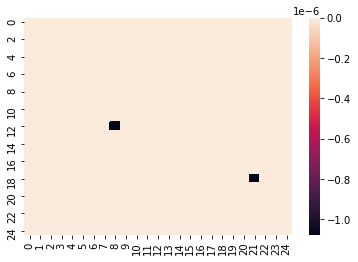

In [250]:
sns.heatmap(dsdt.reshape((nx, ny)))

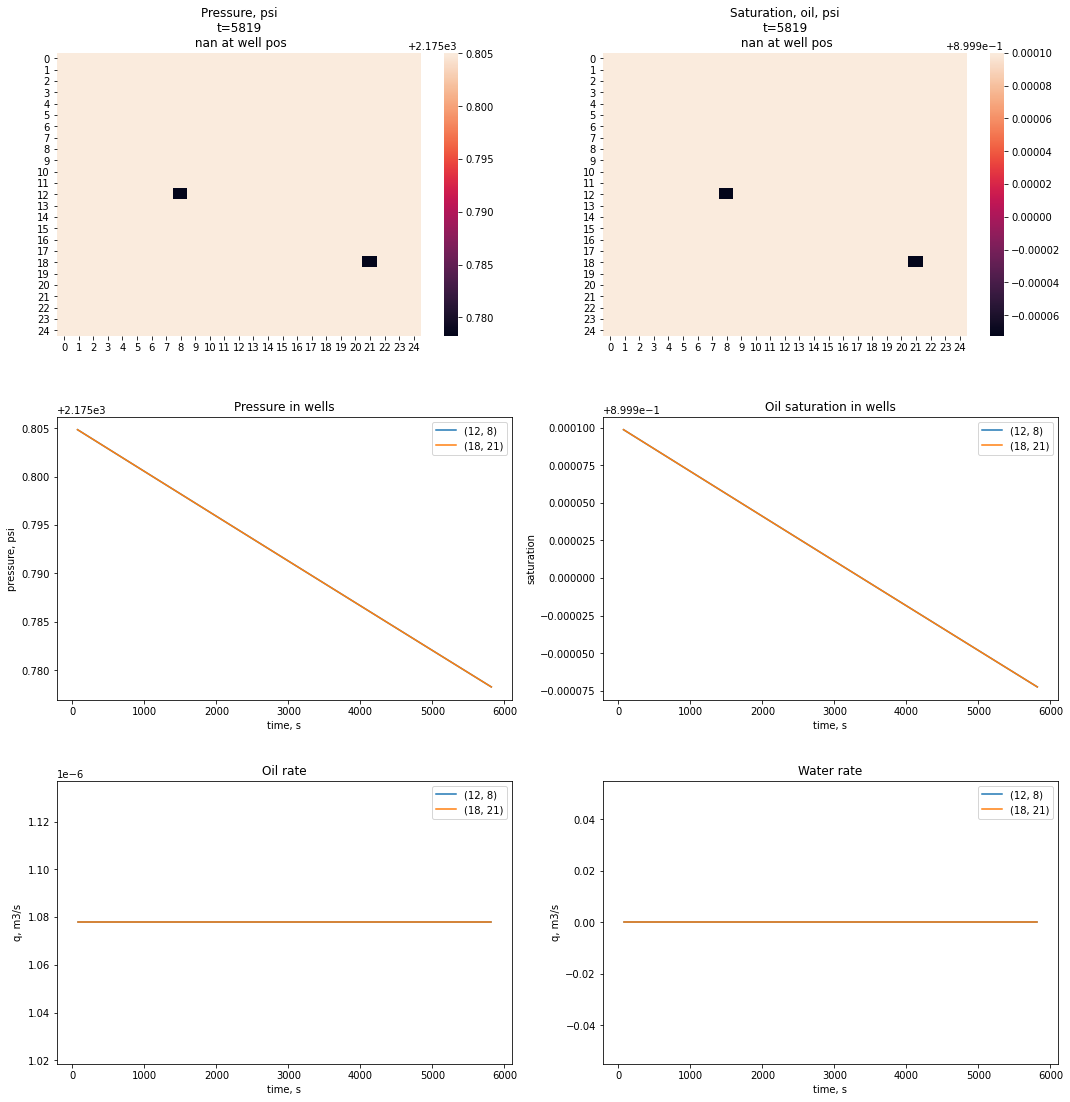

In [ ]:
for i in range(1, n_iter):
    # gonna increase time step
    if t < 60 * 24 * 1: # a day
        dt = 1
    elif 60 * 24 < t < 60 * 24 * 7: # a week
        dt = 2
    elif 60 * 24 * 7 < t < 60 * 24 * 7 * 4 * 2: # 2 month
        dt = 3
    elif 60 * 24 * 7 * 4 * 2 < t < 60 * 24 * 365: # more then 2 month
        dt = 4
    # matrixes depends on saturation
    dt_comp_sat = (dx * dy * d *(s_o.values) * c_o + s_w.values * c_w + np.ones((nx, ny)) * c_r).reshape((-1, 1))
    j_o = get_j_matrix(p=p, s=s_o, mu=mu_o, k=k, B=B_o, pos_r=pos_r, r_ref=r_ref, ph='o')
    j_w = get_j_matrix(p=p, s=s_w, mu=mu_w, k=k, B=B_w, pos_r=pos_r, r_ref=r_ref, ph='w')
    lapl_w = get_lapl_one_ph(p, s_w, mu_w, k, d, dx, dy, 'w')
    lapl_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')
    q_bound_w = get_q_bound(p, s_w, 'w', mu_w)
    q_bound_o = get_q_bound(p, s_o, 'o', mu_o)
    # matrix for implicit pressure
    a = phi * np.eye(nx * ny) * dt_comp_sat - (lapl_w+lapl_o) * dt
    #right hand state for ax = b
    b = phi * dt_comp_sat * p.values.reshape((-1, 1))
    b+= q_bound_w*dt + q_bound_o*dt + (j_o * B_o + j_w * B_w) * delta_p_vec * dt
    # upd time stamp
    t += dt
    # solve p
    p_new = np.linalg.solve(a, b)
    dsdt = lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec
    dsdt += 0 * phi *dx*dy*d * s_o.values.reshape((-1, 1))* (c_o + c_r) * (p_new - p.values.reshape((-1, 1))) / dt
    dsdt /= dx * dy * d * phi
    s_new = (s_o.values.reshape((-1, 1)) + dsdt*dt).reshape((nx, ny))
    # upd sat wat
    s_o = ResState(s_new , s_b) 
    s_w = ResState(np.ones((nx, ny)) - s_o.values, 1 - s_b) 
    p = ResState(p_new.reshape((nx, ny)), p_0)
    if i % plot_freq == 0:
        
        q_o = ((-1) * j_o * (delta_p_vec)).reshape((nx, ny))
        q_w = ((-1) * j_w * (delta_p_vec)).reshape((nx, ny))
        
        # gonna set wells as nan to see gradient
        p_v_disp = p.values.reshape((nx, ny)).copy() / 6894.
        s_o_disp = s_o.values.reshape((nx, ny)).copy()
        
        times.append(t)
        for w in pos_r:
            p_well_hist[w].append(p[w] / 6894.)
            s_o_well_hist[w].append(s_o[w])
            q_o_hist[w].append(q_o[w])
            q_w_hist[w].append(q_w[w])
            # set wells as nan to see gradient
            # p_v_disp[w] = np.nan
            # s_o_disp[w] = np.nan
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
        f.tight_layout(pad=6.0)
        
        sns.heatmap(p_v_disp, ax=ax[0][0], cbar=True)
        ax[0][0].set_title(f'Pressure, psi\nt={t}\n nan at well pos')
        
        sns.heatmap(s_o_disp, ax=ax[0][1], cbar=True, fmt=".2f")
        ax[0][1].set_title(f'Saturation, oil, psi\nt={t}\n nan at well pos')
        
        for w in pos_r:
            ax[1][0].plot(times, p_well_hist[w] , label=f'{w}')
            ax[1][1].plot(times, s_o_well_hist[w] , label=f'{w}')
            ax[2][0].plot(times, q_o_hist[w] , label=f'{w}')
            ax[2][1].plot(times, q_w_hist[w] , label=f'{w}')
        ax[1][0].set_xlabel('time, s')
        ax[1][0].set_ylabel('pressure, psi')
        ax[1][0].set_title('Pressure in wells')
        ax[1][0].legend()
        
        ax[1][1].set_xlabel('time, s')
        ax[1][1].set_ylabel('saturation')
        ax[1][1].set_title('Oil saturation in wells')
        ax[1][1].legend()
        
        ax[2][0].set_xlabel('time, s')
        ax[2][0].set_ylabel('q, m3/s')
        ax[2][0].set_title('Oil rate')
        ax[2][0].legend()
        
        ax[2][1].set_xlabel('time, s')
        ax[2][1].set_ylabel('q, m3/s')
        ax[2][1].set_title('Water rate')
        ax[2][1].legend()
        
        
        plt.show()